In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import time
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

transformer = transforms.Compose([
     transforms.Resize((128, 128)),
     #transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5],
                          [0.5, 0.5, 0.5])
])

In [5]:

train_path='/content/drive/My Drive/real_and_fake_face'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [6]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['training_fake', 'training_real']


In [7]:
transformer=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [8]:
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        self.keep = 0.5

        self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=8)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(num_features=16)
        self.relu2=nn.ReLU()

        self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()

        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.conv4=nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn4=nn.BatchNorm2d(num_features=16)
        self.relu4=nn.ReLU()
        

        self.flatten = nn.Flatten()

        self.fc=nn.Linear(in_features=33*33*16,out_features=625, bias=True)
        self.relu5=nn.ReLU()
        self.dout=nn.Dropout(p=1 - self.keep)

        self.outputs = torch.nn.Linear(625, 2, bias=True)
        
                
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool1(output)
            
        output=self.conv2(output)
        output=self.bn2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        output=self.pool2(output)

        output=self.conv4(output)
        output=self.bn4(output)
        output=self.relu4(output)

        output=self.flatten(output)
                        
        #output=output.view(-1,32*75*75)
        output=self.fc(output)


        output=self.relu5(output)
        output=self.dout(output)
            
            
        #output=self.fc(output)
        output=self.outputs(output) 

        return output

In [9]:
model=network().to(device)

In [10]:
optimizer=Adam(model.parameters(),lr=1e-3,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [11]:
num_epochs=90

In [12]:

train_count=len(glob.glob(train_path+'/**/*.jpg'))
print(train_count)

2041


In [13]:
best_accuracy=0.0

loss_val = []
accurecy_val = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    loss_val.append(train_loss)
    accurecy_val.append(train_accuracy)
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy))
    
    #Save the best model
    if train_accuracy>best_accuracy:
        torch.save(model.state_dict(),'/content/drive/My Drive/Models/mxepmodel.pth')
        best_accuracy=train_accuracy

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 Train Loss: tensor(2.4252) Train Accuracy: 0.5002449779519843
Epoch: 1 Train Loss: tensor(0.6652) Train Accuracy: 0.6085252327290543
Epoch: 2 Train Loss: tensor(0.6307) Train Accuracy: 0.636452719255267
Epoch: 3 Train Loss: tensor(0.6123) Train Accuracy: 0.6575208231259186
Epoch: 4 Train Loss: tensor(0.5683) Train Accuracy: 0.7035766780989711
Epoch: 5 Train Loss: tensor(0.5457) Train Accuracy: 0.7207251347378736
Epoch: 6 Train Loss: tensor(0.5098) Train Accuracy: 0.7437530622243999
Epoch: 7 Train Loss: tensor(0.4491) Train Accuracy: 0.7878490935815776
Epoch: 8 Train Loss: tensor(0.3857) Train Accuracy: 0.8324350808427241
Epoch: 9 Train Loss: tensor(0.3371) Train Accuracy: 0.8530132288094071
Epoch: 10 Train Loss: tensor(0.2931) Train Accuracy: 0.8838804507594317
Epoch: 11 Train Loss: tensor(0.2402) Train Accuracy: 0.9113179813816756
Epoch: 12 Train Loss: tensor(0.1806) Train Accuracy: 0.9372856442920137
Epoch: 13 Train Loss: tensor(0.1472) Train Accuracy: 0.953454189122979
Epoc

Text(0.5, 1.0, 'Accuracy')

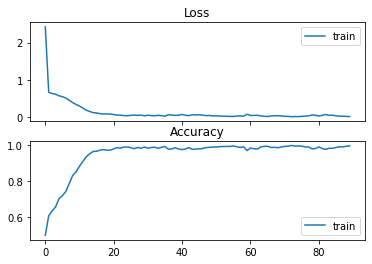

In [14]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(loss_val)
ax1.legend(['train'])
ax1.set_title('Loss')

ax2.plot(accurecy_val)
ax2.legend(['train'])
ax2.set_title('Accuracy')